In [182]:
#
# ESADE - Master in Business Analytics
# Recommendation Systems
# Building a Collaborative Filtering Engine
#
# @ [ David Asi]
#


# imports the libraries
import csv
from math import sqrt

# builds the critics data set
input_file = csv.DictReader(open('./movieratings.csv'))
critics = {}
for row in input_file:
    key = row.pop('User')
    if not key in critics:
        critics[key] = {}
        for item in row:
            if row[item]!='':critics[key][item] = float(row[item])

critics

{'755: John': {'260: Star Wars: Episode IV - A New Hope (1977)': 1.0,
  '1210: Star Wars: Episode VI - Return of the Jedi (1983)': 5.0,
  '356: Forrest Gump (1994)': 2.0,
  '593: Silence of the Lambs, The (1991)': 4.0,
  '3578: Gladiator (2000)': 4.0,
  '1: Toy Story (1995)': 2.0,
  '2028: Saving Private Ryan (1998)': 2.0,
  '1259: Stand by Me (1986)': 3.0,
  '2396: Shakespeare in Love (1998)': 2.0,
  '780: Independence Day (ID4) (1996)': 5.0,
  '541: Blade Runner (1982)': 2.0,
  '2571: Matrix, The (1999)': 4.0,
  "527: Schindler's List (1993)": 2.0,
  '2762: Sixth Sense, The (1999)': 5.0},
 '5277: Maria': {'260: Star Wars: Episode IV - A New Hope (1977)': 5.0,
  '1210: Star Wars: Episode VI - Return of the Jedi (1983)': 3.0,
  '318: Shawshank Redemption, The (1994)': 2.0,
  '593: Silence of the Lambs, The (1991)': 4.0,
  '3578: Gladiator (2000)': 2.0,
  '1: Toy Story (1995)': 1.0,
  '1259: Stand by Me (1986)': 4.0,
  '2396: Shakespeare in Love (1998)': 3.0,
  '2916: Total Recall (1990

### Pearson Correlation Coefficient - User Similarity 

In [211]:
def pearson_similarity(prefs, p1, p2):
    '''
    Returns the Pearson correlation coefficient for p1 and p2.
    '''

    # Compute list of movies that both users have viewed / rated
    mov = {}
    for i in prefs[p1]:
        if i in prefs[p2]:
            mov[i] = 1
            
    # When one of the users did not rate the movie, a '0' will be returned
    if len(mov) == 0:
        return 0
    
    # Sum of items collected
    n = len(mov)
    
    # Compute the sum of the preferences for each of the users
    sum1 = sum([prefs[p1][it] for it in mov])
    sum2 = sum([prefs[p2][it] for it in mov])
    
    # Compute the square of the sums
    sum1Sq = sum([pow(prefs[p1][it], 2) for it in mov])
    sum2Sq = sum([pow(prefs[p2][it], 2) for it in mov])
    
    # Compute the sum of the products 
    pSum = sum([prefs[p1][it] * prefs[p2][it] for it in mov])
    
    # Compute the numerator and denominator of the Pearson formula and calcualte the pearson coefficient r
    numerator = pSum - sum1 * sum2 / n
    denominator = sqrt((sum1Sq - pow(sum1, 2) / n) * (sum2Sq - pow(sum2, 2) / n))
    
    if denominator == 0:
        return 0
    r = numerator / denominator
    
    return r

sim_pearson(critics, '1202: Martina', '139: Nuria')

-0.7130240959073826

### Plotting similarity scores and differences in ratings

In [186]:
def pearsonSimilarity_plot(prefs,person1,person2):
  # TODO
    global x, y
    
    # Create new dataframe with ratings of the 2 users for analysis, 
    # dropping NA entries to only compare movie for which both users gave a rating.
    # Create numpy array (allows for faster computations) and apply the pearson correlation function of the scipy.stats library
    
    new_prefs = prefs[(prefs['User'] == person1) | (prefs['User'] == person2)] 
    new_prefs = new_prefs.dropna(axis = 1)

    x = new_prefs[new_prefs['User'] == person1].values
    x = np.delete(x,0)

    y = new_prefs[new_prefs['User'] == person2].values
    y = np.delete(y,0)
  
    return x, y

pearsonSimilarity(prefs = prefs, person1 = '1202: Martina',person2 = '139: Nuria')

(array([4.0, 3.0, 4.0, 4.0, 5.0, 3.0], dtype=object),
 array([3.0, 5.0, 2.0, 2.0, 3.0, 5.0], dtype=object))

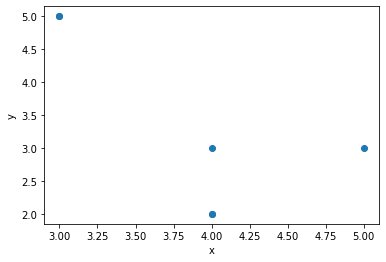

Text(0, 0.5, 'y')

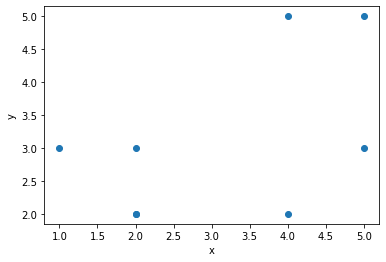

In [225]:
# plot x and y
import matplotlib.pyplot as plt

plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

pearsonSimilarity(prefs = prefs, person1 = '755: John',person2 = '139: Nuria')
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')

# The first pair of users has a Pearson correlation of -0.71, which is strongly negative.
# This means, that if person 1 has highly positive ratings for a movie, person 2 has rather negative reviews.
# Conversely, if person 1 has highly negative ratings for a movie, person 2 tends to have rather positive reviews.
# This can be seen in the scatter plot: for 1 point, x gives a rating of 3, while y gives a rating of 5. 
# For another point that person 1 rates highly (4), person 2 only gives a rating of 2.
# Compared to 2 users with a slightly positive correlation (~0.3), one can say that as one of them rates a movie higher, the other person has also rated that movie more positively (and vice versa)

### Get Top Recommendations for Users based on the Pearson Correlation

In [218]:
# Gets recommendations for person by using a weighted average of every other user's rankings
#
# Output example:
# [ (4.384834278347329, '2344: Sixth Sense, The (1999)'), 
#   (4.192391938482591, '2111: Saving Private Ryan (1998)'), 
#   (3.939493847382943, '3434: Forrest Gump (1994)'), 
#   (3.202023092992929, '3432: Blade Runner (1982)'), 
#   (2.929929928282816, '2342: Matrix, The (1999)'), 
#   (2.339434934923433, '3242: Shakespeare in Love (1998)'), 
#   (1.999329929223814, '2222: Shawshank Redemption, The (1994)')]

def getRecommendations(prefs, person, similarity=pearson_similarity):

    ratings = {}
    weights = {}
    
    for i in prefs:
        if i == person:    # Does not consider the user against the user him/herself for the correlation calculation
            continue
        weight = similarity(prefs, person, i)

        if weight <= 0:           # Does not consider scores of zero or lower
            continue
            
        for item in prefs[i]:
            
            if item not in prefs[person] or prefs[person][item] == 0:    # Does only consider movies the respective user has not yet seen
                ratings.setdefault(item, 0)
                ratings[item] += prefs[i][item] * weight    # Score calculation - item multiplied by the weight (similarity coefficient) and added

                weights.setdefault(item, 0)                 # Computes the sum of the weights
                weights[item] += weight
                 
    rankings = [(rating / weights [item], item) for (item, rating) in ratings.items()]   # Completed score prediction formula 

    rankings.sort()
    rankings.reverse()
    return rankings

getRecommendations(critics, '4656: Victoria', similarity=pearson_similarity)

[(3.8049292273876776, '2571: Matrix, The (1999)'),
 (3.2524041158050325, '318: Shawshank Redemption, The (1994)'),
 (3.001761291308658, '356: Forrest Gump (1994)'),
 (2.998776571794391, '2396: Shakespeare in Love (1998)'),
 (2.7754525984282155, '2762: Sixth Sense, The (1999)'),
 (2.15187248710089, '541: Blade Runner (1982)'),
 (1.7964811259693814, '2028: Saving Private Ryan (1998)')]

### Get Top User Matches

In [220]:
def topMatches(prefs, person, n=5,similarity=pearson_similarity):

    # Retrieves the top n matches for the specific user from the critics dictionary
    scores = [(similarity(prefs, person, i), i) for i in prefs
              if i != person]
    scores.sort()
    scores.reverse()
    return scores[0:n]

topMatches(critics, '1202: Martina', similarity=pearson_similarity)

[(0.5765566601970546, '4796: Ivan'),
 (0.3108809141790292, '5277: Maria'),
 (0.1703885502741196, '5347: Marc'),
 (0.15269288915036527, '4388: Roger'),
 (0.10701922170955337, '1577: Anton')]

# Running the functions on the top 1m dataset

In [162]:
def load_datasets(movie_data, user_data, rating_data):
    global movies, ratings
    movies = pd.read_csv(movie_data, sep='::', names = ['ID','Movie','Genre'],encoding='latin-1')

# Load user data: ID, age, sex, occupation, zip_code
    u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
    users = pd.read_csv(user_data, sep='::', names=u_cols, encoding='latin-1')

# Load ratings data: User ID, Movie ID, rating, timestamp
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv(rating_data, sep='::', names=r_cols, encoding='latin-1')

load_datasets(movie_data = 'movies.dat', user_data = 'users.dat', rating_data = 'ratings.dat')

<ipython-input-162-2d943797e4a6>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv(movie_data, sep='::', names = ['ID','Movie','Genre'],encoding='latin-1')
<ipython-input-162-2d943797e4a6>:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv(user_data, sep='::', names=u_cols, encoding='latin-1')
<ipython-input-162-2d943797e4a6>:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
 

In [163]:
# Create one merged DataFrame
def create_dataset(movies, ratings):
    global movie_ratings
    movie_ratings = movies.merge(ratings,left_on = 'ID',right_on = 'movie_id')
    print('The shape of the dataset is:' + str(movie_ratings.shape))

create_dataset(movies, ratings)

The shape of the dataset is:(1000209, 7)


In [164]:
# Reshape dataframe so it has the same format as the initial dataset: User as index, movie as column
# Output: Sparse matrix with many missing values
def transform_dataset(movie_ratings):
    movie_mio = movie_ratings.pivot_table(index="user_id", columns="Movie", values="rating",aggfunc='mean')
    movie_mio.to_csv('./movie_mio.csv')

transform_dataset(movie_ratings)

In [165]:
movie_ratings.head()

ID             Movie                        Genre  user_id  movie_id  \
0   1  Toy Story (1995)  Animation|Children's|Comedy        1         1   
1   1  Toy Story (1995)  Animation|Children's|Comedy        6         1   
2   1  Toy Story (1995)  Animation|Children's|Comedy        8         1   
3   1  Toy Story (1995)  Animation|Children's|Comedy        9         1   
4   1  Toy Story (1995)  Animation|Children's|Comedy       10         1   

   rating  unix_timestamp  
0       5       978824268  
1       4       978237008  
2       4       978233496  
3       5       978225952  
4       5       978226474

In [166]:
movie_ratings.drop(['ID','Genre','movie_id','unix_timestamp'], axis =1,inplace=True)
movie_ratings = movie_ratings.reindex(columns=['user_id','Movie','rating'])
movie_ratings = movie_ratings.pivot(index="user_id", columns="Movie", values="rating")
movie_ratings.to_csv('1m_movie_ratings')

input_file = csv.DictReader(open('./1m_movie_ratings'))
critics = {}
for row in input_file:
    key = row.pop('user_id')
    if not key in critics:
        critics[key] = {}
        for item in row:
            if row[item]!='':critics[key][item] = float(row[item])

critics

{'1': {'Airplane! (1980)': 4.0,
  'Aladdin (1992)': 4.0,
  'Antz (1998)': 4.0,
  'Apollo 13 (1995)': 5.0,
  'Awakenings (1990)': 5.0,
  'Back to the Future (1985)': 5.0,
  'Bambi (1942)': 4.0,
  'Beauty and the Beast (1991)': 5.0,
  'Ben-Hur (1959)': 5.0,
  'Big (1988)': 4.0,
  "Bug's Life, A (1998)": 5.0,
  'Christmas Story, A (1983)': 5.0,
  'Cinderella (1950)': 5.0,
  'Close Shave, A (1995)': 3.0,
  'Dead Poets Society (1989)': 4.0,
  'Driving Miss Daisy (1989)': 4.0,
  'Dumbo (1941)': 5.0,
  'E.T. the Extra-Terrestrial (1982)': 4.0,
  'Erin Brockovich (2000)': 4.0,
  'Fargo (1996)': 4.0,
  "Ferris Bueller's Day Off (1986)": 4.0,
  'Gigi (1958)': 4.0,
  'Girl, Interrupted (1999)': 4.0,
  'Hercules (1997)': 4.0,
  'Hunchback of Notre Dame, The (1996)': 4.0,
  'James and the Giant Peach (1996)': 3.0,
  'Last Days of Disco, The (1998)': 5.0,
  'Mary Poppins (1964)': 5.0,
  'Meet Joe Black (1998)': 3.0,
  'Miracle on 34th Street (1947)': 4.0,
  'Mulan (1998)': 4.0,
  'My Fair Lady (1964

In [180]:
pearson_similarity(critics, '1', '2')

0.4166666666666646

In [168]:
getRecommendations(critics, '1', similarity=pearson_similarity)

[(5.000000000000001, 'Paris, France (1993)'),
 (5.000000000000001, "Ed's Next Move (1996)"),
 (5.0, 'Ulysses (Ulisse) (1954)'),
 (5.0, 'Smashing Time (1967)'),
 (5.0, 'Message to Love: The Isle of Wight Festival (1996)'),
 (5.0, 'Man of the Century (1999)'),
 (5.0, 'I Got the Hook Up (1998)'),
 (5.0, 'I Am Cuba (Soy Cuba/Ya Kuba) (1964)'),
 (5.0, 'Dangerous Game (1993)'),
 (5.0, 'Criminal Lovers (Les Amants Criminels) (1999)'),
 (5.0, 'Country Life (1994)'),
 (5.0, 'Callejón de los milagros, El (1995)'),
 (5.0, 'Born American (1986)'),
 (5.0, 'Bittersweet Motel (2000)'),
 (5.0, 'Bells, The (1926)'),
 (4.984968617071785, 'Apple, The (Sib) (1998)'),
 (4.9508637341995785, 'Firelight (1997)'),
 (4.857742318504138, 'Inheritors, The (Die Siebtelbauern) (1998)'),
 (4.847913150913047, 'Aparajito (1956)'),
 (4.831451314054679, 'Lamerica (1994)'),
 (4.703105029951299, 'Modulations (1998)'),
 (4.700161221459394, 'Go Now (1995)'),
 (4.673977885406672, 'Kika (1993)'),
 (4.672701813262053, 'Saltmen 

In [174]:
topMatches(critics, '1', n=5, similarity=pearson_similarity)

[(1.000000000000004, '4106'),
 (1.000000000000004, '298'),
 (1.0000000000000033, '3111'),
 (1.0000000000000022, '2318'),
 (1.0000000000000018, '1877')]

### Findings
Even on the 1 mio rating data set, all the algorithms that were defined run extremely fast, almost without performance loss